In [10]:
import os

# Step 1: Understanding French Orthography
Forget about grapheme-morpheme conversion because the orthography is garbage.


# Step 2: Test Their Code

In [1]:
import OLD
OLD.main(["Old.py"])
#OLD.main(["Old.py","-t"])

fra: 0.886
Average accuracy 0.886


# Step 3: Fixing Their Bugs
Turns out test doesn't work but we can fix the main method and get it running again.

In [5]:
import OldButTestWorks
print("Dev accuracy:")
OLD.main(["Old.py"])
print("\nTest accuracy:")
OldButTestWorks.main(["Old.py","-t"])

Dev accuracy:
fra: 0.886
Average accuracy 0.886

Test accuracy:
fra: 0.777
Average accuracy 0.777


# Step 4: Figuring Out What Went Wrong
We took the data given to us from fra.dev and fra.tst and compared it to the fra.out files we received back using an online tool:
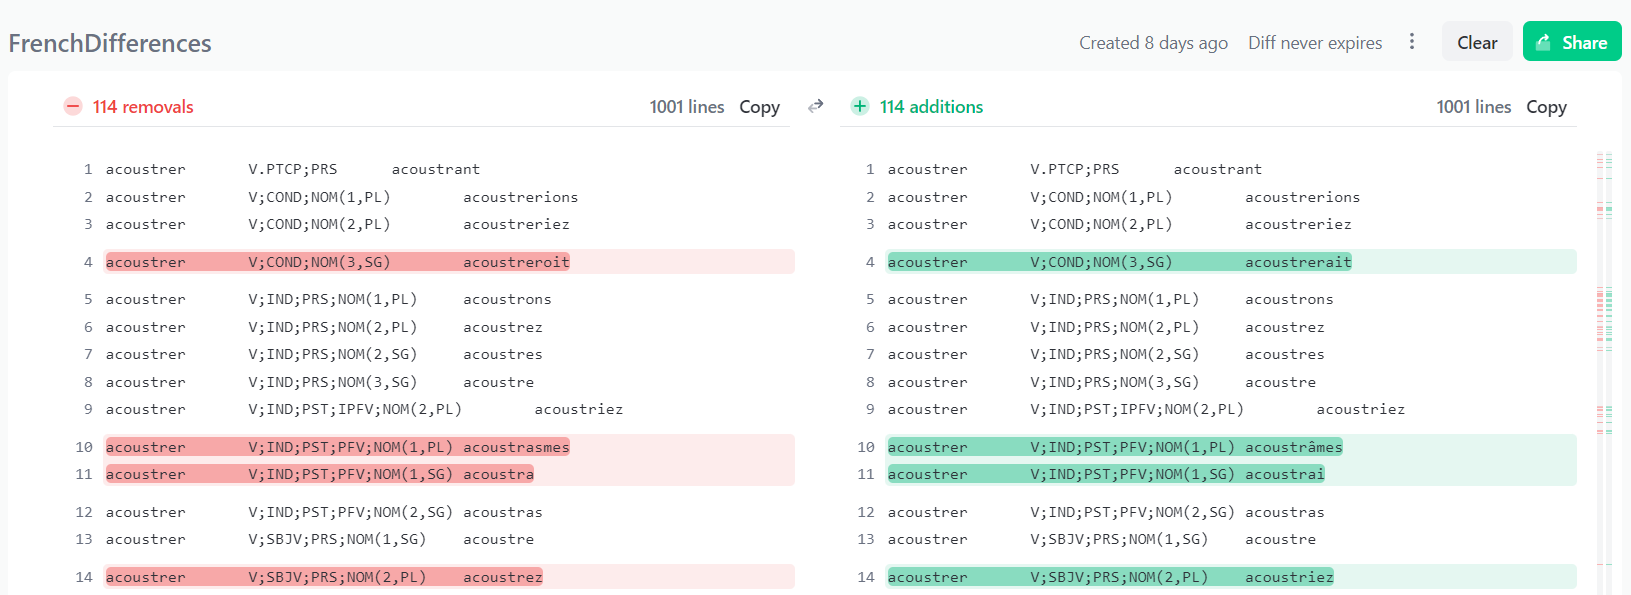
Here you can see the first few differences between fra.dev and what the program generated. We then created a tool that could check through both files and find the words that were causing issues:

In [11]:
#Generate Output file
OLD.main(["Old.py","-o"])

###  Initialize storage for output later  ###

diffLineCounter = 0
problemWords = {}
problemWordErrors = {}

###  Loop through the dev and out files pairwise using zip, finding the problematic words  ###

with open('./data/fra.dev','r') as inFile, open('./Data/fra.out','r') as outFile:
    for inLine, outLine in zip(inFile, outFile):
        if inLine != outLine:
            #Grab the lemma
            inLineSplit = inLine.strip().split("\t")
            curWord = inLineSplit[0]
            diffLineCounter += 1
            if curWord not in problemWords.keys():
                problemWords[curWord] = 1
            else:
                problemWords[curWord] += 1

###  Output the broken words to a text file  ###
                
problemWordsList = sorted(problemWords.items(), key=lambda item: item[1], reverse=True)
with open("./WordsWithIssues.txt",'w') as WordsWithIssues:
    WordsWithIssues.write("Count\tWord\n")
    for x in problemWordsList:
        WordsWithIssues.write("%s\t%s\n" % (x[1],x[0]))

fra: 0.886
Average accuracy 0.886


In [9]:
with open("./WordsWithIssues.txt","r") as file:
    print(file.read())

Count	Word
12	prÃ©lever
11	ouÃ¯r
10	contrepleder
10	reteindre
10	tuner
9	craqueler
7	broicher
6	culcher
6	dÃ©layer
5	acoustrer
5	desregler
5	mendier
4	dÃ©sarmer
4	terser
2	recomparaitre
2	surbooker
2	sÃ©quencer
1	alanguir
1	investir
1	larder
1	objectiver



So now we have a list of words that are giving us trouble. The question now becomes "Why?"

**[INSERT WORD PATTERN FRENCH STUFF HERE]**

# Step 5: Tools First
We made a tool at this point to help us see what was going on inside this mess of a file. This consisted of making another file `fra.dbg` and a new flag that runs the program only on that file, and prints out some useful info. We added some print statements at certain points like so
```Python
def apply_best_rule(lemma, msd, allprules, allsrules, debug=False):
    if debug: print("Lemma: %s\nFeatures: %s" % (lemma, msd))
    ...
    if applicablerules:
            bestrule = max(applicablerules, key = lambda x: (len(x[0]), x[2], len(x[1])))
            if debug: print("\nApplicable suffix rules:\n%s\nUsing: %s" % (applicablerules, bestrule))
            base = base.replace(bestrule[0], bestrule[1])
```
These are not all the places we added printing but it gives you an idea of how it was implemented.

Then we had to add the option to main the same way we resolved the 'testing doesn't work' issue from before.
```Python
def main(argv):
    options, remainder = getopt.gnu_getopt(argv[1:], 'odthp:', ['output','debug','test','help','path='])
    DEBUG, TEST, OUTPUT, HELP, path = False,False,False, False, './data/'
    ...
    if opt in ('-d', '--debug'):
        DEBUG = True
    ...
    if DEBUG:
        devlines = [line.strip() for line in open(path + lang + ".dbg", "r", encoding='utf8') if line != '\n']
    ...
    outform = apply_best_rule(lemma, msd, allprules, allsrules, DEBUG)
```
Now that we had these tools, we could modify `fra.dbg` with a few words we were struggling against to see what was going wrong.

In [12]:
import DebugModeAdded
DebugModeAdded.main(["DebugModeAdded.py", "-d"])

Lemma: acoustrer
Features: V;COND;NOM(3,SG)

Applicable suffix rules:
[('>', 'it>', 206), ('>', '>', 210), ('>', 'ait>', 154), ('r>', 'rait>', 154), ('>', 't>', 206), ('er>', 'erait>', 144), ('r>', 'roit>', 44), ('er>', 'eroit>', 43), ('>', 'oit>', 44), ('r>', 't>', 4), ('rer>', 'reroit>', 2), ('rer>', 'rerait>', 11)]
Using: ('rer>', 'rerait>', 11)

Applicable prefix rules:
[('<', '<', 209), ('<a', '<a', 19), ('<ac', '<ac', 1), ('<', '<se ', 1)]
Using: ('<', '<', 209)
fra: 0.0
Average accuracy 0.0


As you can see, we now have access to all of the rules it can choose from when trying to modify this form. Unfortunately, it picks the wrong one :/
# Step 6: Try To Fix It
### Pt. 1: The elusive `ll`
We noticed that there was an issue with some words that have `ll` in their spelling but we're being generated with only one `l`. Somebody brought up that this was related to being at the end of the syllable or possibly silent `e`s. The files we had been given had no syllable markers in their IPA, so we tried to make a syllabifier beceause it couldn't be that hard. (Spoiler alert: It was very hard)

This was our first attempt:
```Python
def syllabifyWord(line, debug=False):
    lineSplit = line.strip().split("\t")
    orthography, ipa = lineSplit[0], lineSplit[1].split(" ")
    spot = len(ipa) - 1
    out = []
    while spot >= 0:
        #CODA
        while ipa[spot] in CONSONANTS and spot > 0:
            out.insert(0,ipa[spot])
            spot -= 1
        #NUCLEUS
        out.insert(0,ipa[spot])
        spot -= 1
        #GLIDE
        if ipa[spot] in 'jɥw':
            out.insert(0,ipa[spot])
            spot -= 1
        #ONSET
        if spot >= 0:
            out.insert(0,ipa[spot])
            spot -= 1
            if ipa[spot+1] in 'lʁ' and ipa[spot] not in 'lʁ' and ipa[spot] in CONSONANTS:
                out.insert(0,ipa[spot])
                spot -= 1
        out.insert(0,'.')
    out.remove('.')
    outString = ''.join(out)
    if debug: print("%-15s  %-15s %-15s" % (orthography,''.join(ipa), outString))
    return outString
```
The idea was to work backwards through the IPA and use phonotactic constraints to insert the boundaries. Unfortunately there are very few resources on French syllable phonotactic constraints with the exception of this paper (Which I spent way to long trying to understand -Sandro)
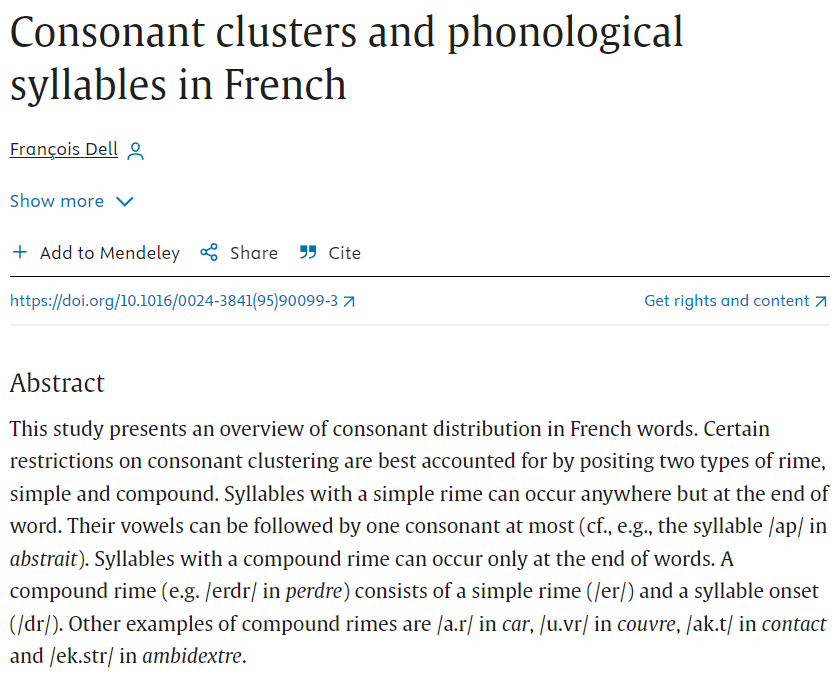

Turns out the rules that people do know are wishy-washy and wonky at best. Sooooooo......

### Pt. 2: Stealing syllable boundaries from Wiktionary
We just scraped it all from the internet because once again French is garbage :)

So now all we had to do was line the IPA sounds up with the spelling and we can figure out when it needs to be `ll` instead of `l`. (Spoiler alert: This didn't work either)

Remember step 1? Well we should have listened and steared clear. There is no way we could have made a program that figures out where a silent `e` is in this amount of time. So anyways, we diverted power to the next idea because this one was about ready to crash and burn.

### Pt 3: What about the Old and Middle French words?
You might be wondering what we're talking about. This is about French. Why should we worry about old French? Well, for whatever reason, there's a handful of Old French, Middle French, Outdated French, and other words that are nigh unusable **[INSERT WORD ABOUT PLOWING THE THIRD TIME]** To get around some of these words with ridiculous ending patterns, one solution was disregarding patterns that showed up only one time in the `fra.dev` file. This prevents an overly specific rule from some obscure word affecting other words improperly.

In [13]:
#INSERT VERSION WITH THIS CHANGE AND CALL IT TO SEE RESULTS

### Pt 4: What if we are smarter about the stupid words?

**[INSERT STUFF ABOUT CLASSIFYING THE WORDS]**

In [14]:
#INSERT VERSION WITH THIS CHANGE AND CALL IT TO SEE RESULTS

### Pt 5: 

**[INSERT STUFF ABOUT `er` WORDS AND TITLE]**

In [15]:
#INSERT VERSION WITH THIS CHANGE AND CALL IT TO SEE RESULTS

### Pt 6: Maybe it's smart enough now

**[INSERT STUFF ABOUT REMOVING THE FREQUENCY=1 RULE]**

# Step 7: Make an Interactive Notebook

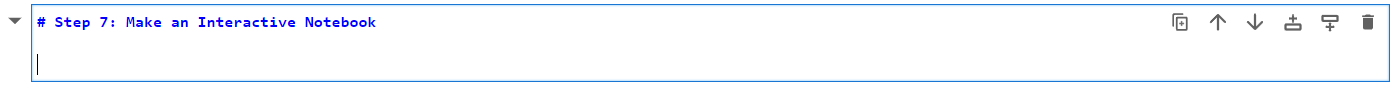

In our notebook we'll need our data well organized:
|Version|`fra.dev`|`fra.tst`|
|---|---|---|
|OLD|88.6%|---|
|OldButTestingWorks|88.6%|77.7%|
|IgnoreInfrequentRules||
|IgnoreOldFrenchToo||
|OnlyIgnoreOldFrench||